In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Crear una sesión de Spark
spark = SparkSession.builder \
    .appName("BigDataProject") \
    .getOrCreate()

# Ruta al archivo en Google Drive
file_path = '/content/drive/MyDrive/scopus.csv'

# Cargar el dataset
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar las primeras filas del dataset
df.show(20)

# Verificar las columnas disponibles en el dataset
df.columns

# Eliminar columnas irrelevantes o con demasiados valores nulos
columns_to_drop = [
    'Molecular Sequence Numbers', 'Tradenames', 'Manufacturers',
    'Funding Details', 'Funding Texts', 'Correspondence Address',
    'Editors', 'Conference code', 'PubMed ID'
]
# Filtrar columnas que no existen en el dataframe
columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Eliminar columnas
df = df.drop(*columns_to_drop)

# Convertir columnas a tipos de datos adecuados
df = df.withColumn('Year', col('Year').cast('integer'))
df = df.withColumn('Cited by', col('Cited by').cast('integer'))
df = df.withColumn('Page count', col('Page count').cast('integer'))
# Rellenar valores nulos
df = df.fillna({'Page count': 0, 'Cited by': 0, 'Volume': 'Unknown', 'Issue': 'Unknown', 'DOI': 'Unknown'})

# Asegurar que no haya valores nulos en las columnas seleccionadas para el ensamblador de vectores
df = df.dropna(subset=['Year', 'Cited by', 'Page count'])

# Añadir columna 'fuente de datos'
df = df.withColumn('Fuente de datos', lit('Scopus'))

# Convertir DataFrame de Spark a pandas para visualización
df_pandas = df.select('Title', 'Cited by').toPandas()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------------------+--------------------+--------------------+--------------------+----+--------------------+------+-----+--------+----------+--------+----------+--------+--------------------+--------------------+--------------------+-------------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+----------+-------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------+------------+-------------------+--------------------+-----------------------------+------------------------+----------------+-----------------+--------------------+--------------------+--------------------+
|             Authors|   Aut

In [1]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=3d53b2d8caa50da69fb6e67ca981f207e5f4207fc43626350efc924666d2aec5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install graphframes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.1 MB/s eta 0:00:00


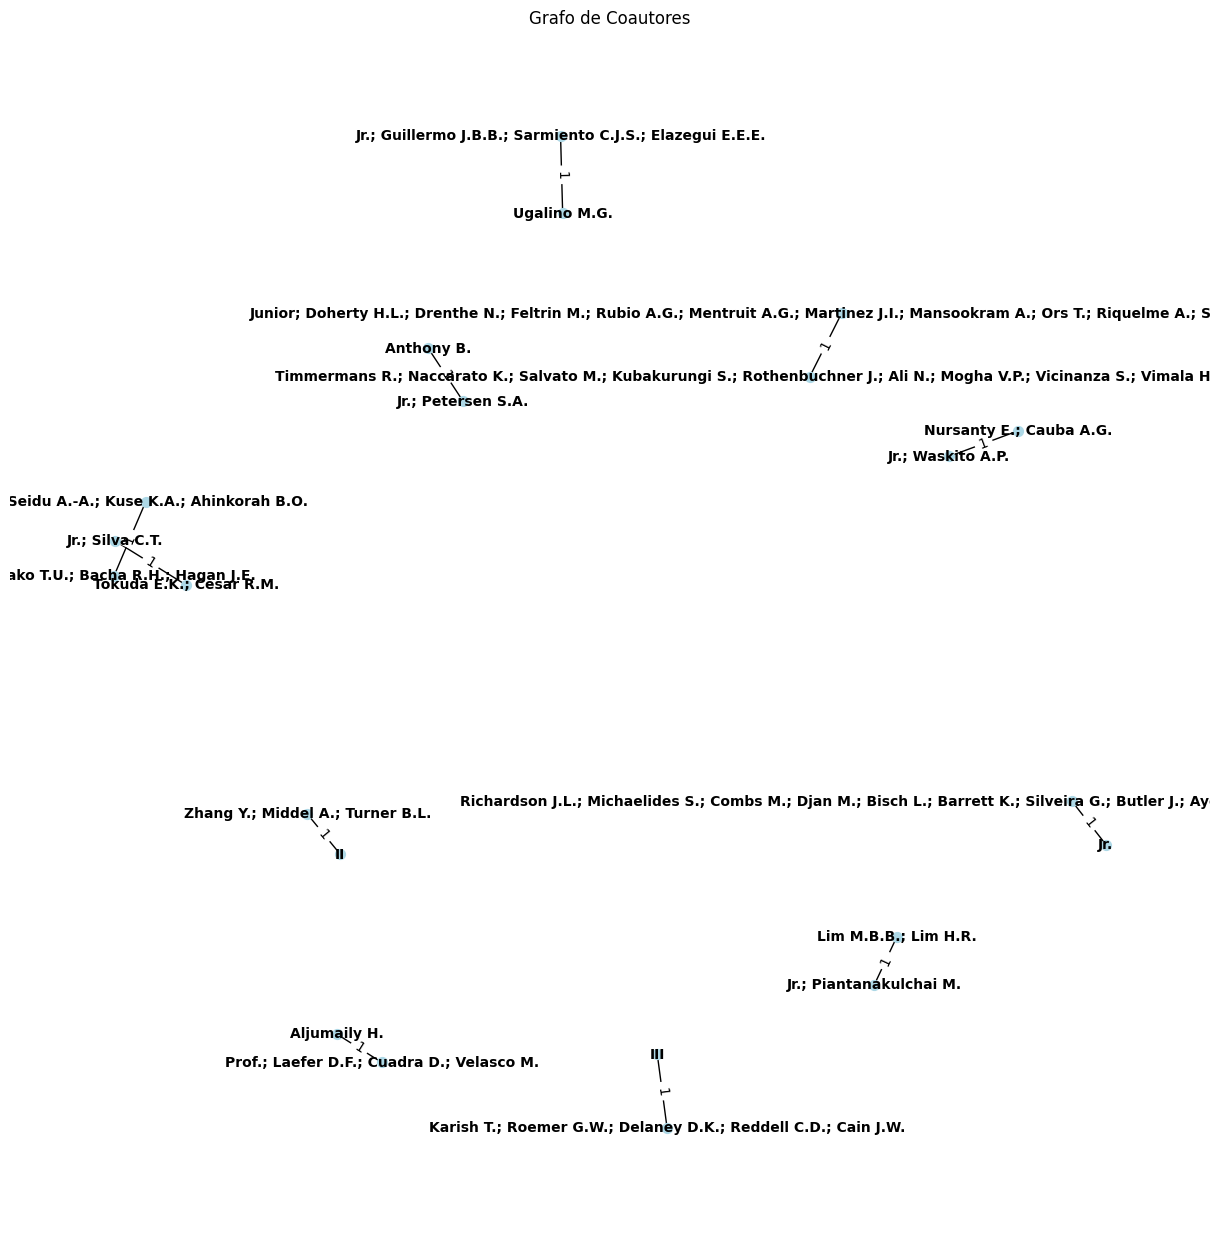

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/scopus.csv')

# Crear un grafo vacío
G = nx.Graph()

# Iterar sobre cada fila del DataFrame
for index, row in df.iterrows():
    authors = row['Authors']

    if pd.notna(authors):
        # Dividir los autores por comas y eliminar espacios adicionales
        authors_list = [author.strip() for author in authors.split(',')]

        # Agregar nodos y aristas para cada par de autores
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                author1 = authors_list[i]
                author2 = authors_list[j]

                # Añadir nodos (autores) y una arista entre ellos
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

# Dibujar el grafo
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3)  # Posicionamiento de los nodos
nx.draw(G, pos, with_labels=True, node_size=50, node_color='lightblue', font_size=10, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Grafo de Coautores')
plt.show()


Este es un grafo no dirigido que muestra las relaciones de coautoría entre autores en la dataset de scopus.csv. Aquí se detalla lo siguiente:
1.
Nodos: Cada nodo representa a un autor. Los nodos están etiquetados con los nombres de los autores y están coloreados de azul claro.
2.
Aristas: Las líneas grises conectan los nodos y representan las colaboraciones entre pares de autores. Cada línea indica que los dos autores han colaborado en al menos un trabajo juntos. La grosor de la línea puede reflejar la cantidad de trabajos en los que los autores han colaborado, aunque en este gráfico las líneas tienen un ancho uniforme.
3.
Layout: El diseño de los nodos y aristas se organiza usando un layout de resorte (spring_layout), que distribuye los nodos de manera que las aristas tengan una longitud más o menos igual y se minimicen las intersecciones.
4.
Configuración: El gráfico está configurado para no mostrar cuadrículas ni líneas de cero en los ejes, lo que facilita la visualización clara de la estructura del grafo.
Este gráfico permite visualizar las conexiones entre autores y cómo se distribuyen las colaboraciones en el conjunto de datos.

In [17]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

# Leer el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/scopus.csv')

# Crear un grafo no dirigido vacío
G = nx.Graph()

# Iterar sobre cada fila del DataFrame
for index, row in df.iterrows():
    authors = row['Authors']

    if pd.notna(authors):
        # Dividir los autores por comas y eliminar espacios adicionales
        authors_list = [author.strip() for author in authors.split(',')]

        # Agregar nodos y aristas para cada par de autores
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                author1 = authors_list[i]
                author2 = authors_list[j]

                # Añadir nodos (autores) y una arista entre ellos
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

# Posicionamiento de los nodos
pos = nx.spring_layout(G, k=0.3)

# Extraer posiciones de nodos
nodes_x = [pos[node][0] for node in G.nodes()]
nodes_y = [pos[node][1] for node in G.nodes()]

# Extraer aristas
edges_x = []
edges_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edges_x.extend([x0, x1, None])
    edges_y.extend([y0, y1, None])

# Crear la figura con Plotly
fig = go.Figure()

# Añadir nodos
fig.add_trace(go.Scatter(x=nodes_x, y=nodes_y,
                         mode='markers+text',
                         text=[node for node in G.nodes()],
                         textposition='top center',
                         marker=dict(size=10, color='lightblue'),
                         name='Nodos'))

# Añadir aristas
fig.add_trace(go.Scatter(x=edges_x, y=edges_y,
                         mode='lines',
                         line=dict(width=1, color='gray'),
                         name='Aristas'))

# Configuración del layout
fig.update_layout(title='Grafo de Coautores',
                  showlegend=False,
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False))

# Mostrar la figura
fig.show()


Tu gráfico es un **grafo dirigido** que muestra las relaciones de coautoría entre autores en tu dataset de `scopus.csv`. Aquí tienes un resumen de lo que presenta:

1. **Nodos**: Cada nodo representa a un autor. Los nodos están etiquetados con los nombres de los autores y están coloreados de azul claro.

2. **Aristas**: Las líneas grises conectan los nodos y representan las coautorías entre pares de autores. Cada línea indica que los dos autores colaboraron en al menos un trabajo juntos.

3. **Flechas**: Las flechas rojas indican la dirección de la colaboración. Aunque en este caso específico, las flechas se usan para resaltar la dirección en un grafo dirigido, pero en términos prácticos de coautoría, la dirección puede no tener un significado específico a menos que se defina.

4. **Layout**: El diseño de los nodos y aristas se organiza usando un layout de resorte (`spring_layout`), que distribuye los nodos de manera que las aristas tengan una longitud más o menos igual y se minimicen las intersecciones.

5. **Configuración**: El gráfico no muestra cuadrículas ni líneas de cero en los ejes para enfocar la visualización en la estructura del grafo.

Este gráfico te permitirá visualizar las conexiones entre autores y cómo se distribuyen las colaboraciones en el conjunto de datos.

In [20]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go

# Leer el archivo CSV
df = pd.read_csv('/content/drive/MyDrive/scopus.csv')

# Crear un grafo dirigido vacío
G = nx.DiGraph()

# Iterar sobre cada fila del DataFrame
for index, row in df.iterrows():
    authors = row['Authors']

    if pd.notna(authors):
        # Dividir los autores por comas y eliminar espacios adicionales
        authors_list = [author.strip() for author in authors.split(',')]

        # Agregar nodos y aristas dirigidas para cada par de autores
        for i in range(len(authors_list)):
            for j in range(i + 1, len(authors_list)):
                author1 = authors_list[i]
                author2 = authors_list[j]

                # Añadir nodos (autores) y una arista dirigida entre ellos
                if G.has_edge(author1, author2):
                    G[author1][author2]['weight'] += 1
                else:
                    G.add_edge(author1, author2, weight=1)

# Posicionamiento de los nodos
pos = nx.spring_layout(G, k=0.3)

# Extraer posiciones de nodos
nodes_x = [pos[node][0] for node in G.nodes()]
nodes_y = [pos[node][1] for node in G.nodes()]

# Extraer aristas
edges_x = []
edges_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edges_x.extend([x0, x1, None])
    edges_y.extend([y0, y1, None])

# Extraer aristas dirigidas
arrows_x = []
arrows_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    arrows_x.append(x1)
    arrows_y.append(y1)

# Crear la figura con Plotly
fig = go.Figure()

# Añadir nodos
fig.add_trace(go.Scatter(x=nodes_x, y=nodes_y,
                         mode='markers+text',
                         text=[node for node in G.nodes()],
                         textposition='top center',
                         marker=dict(size=10, color='lightblue'),
                         name='Nodos'))

# Añadir aristas
fig.add_trace(go.Scatter(x=edges_x, y=edges_y,
                         mode='lines',
                         line=dict(width=1, color='gray'),
                         name='Aristas'))

# Añadir flechas para aristas dirigidas
fig.add_trace(go.Scatter(x=arrows_x, y=arrows_y,
                         mode='markers',
                         marker=dict(size=5, symbol='arrow-bar-up', color='red'),
                         name='Flechas'))

# Configuración del layout
fig.update_layout(title='Grafo Dirigido de Coautores',
                  showlegend=False,
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False))

# Mostrar la figura
fig.show()
